#  Прогнозирование заказов такси

**Описание проекта:**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных:**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**План работы:**

[1  Подготовка](#section1)

[2  Анализ](#section2)

[3  Обучение](#section3)

[4  Тестирование и итоговй анализ](#section4)


<a id='section1'></a>
## Подготовка

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Загрузим данные из файлов, выведем первые 10 строк таблиц для первого взгляда на данные.
Также с помощью метода info() изучим структуры таблиц: типы данных, количество строк, столбцов, пропущенных данных

In [4]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi.shape

(26496, 1)

Выполним ресемплирование данных по одному часу. Поскольку предсказываем количество заказов такси на следующий час, аггрегируем суммы значений.

In [5]:
taxi = taxi.sort_index()
taxi = taxi.resample('1H').sum()

In [6]:
f"Временной промежуток данных: {taxi.index.min()} - {taxi.index.max()}"

'Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00'

**Вывод:**

Данные подготовлены к анализу

<a id='section2'></a>
## Анализ

Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики последнего месяца временного ряда и проанализируем данные.

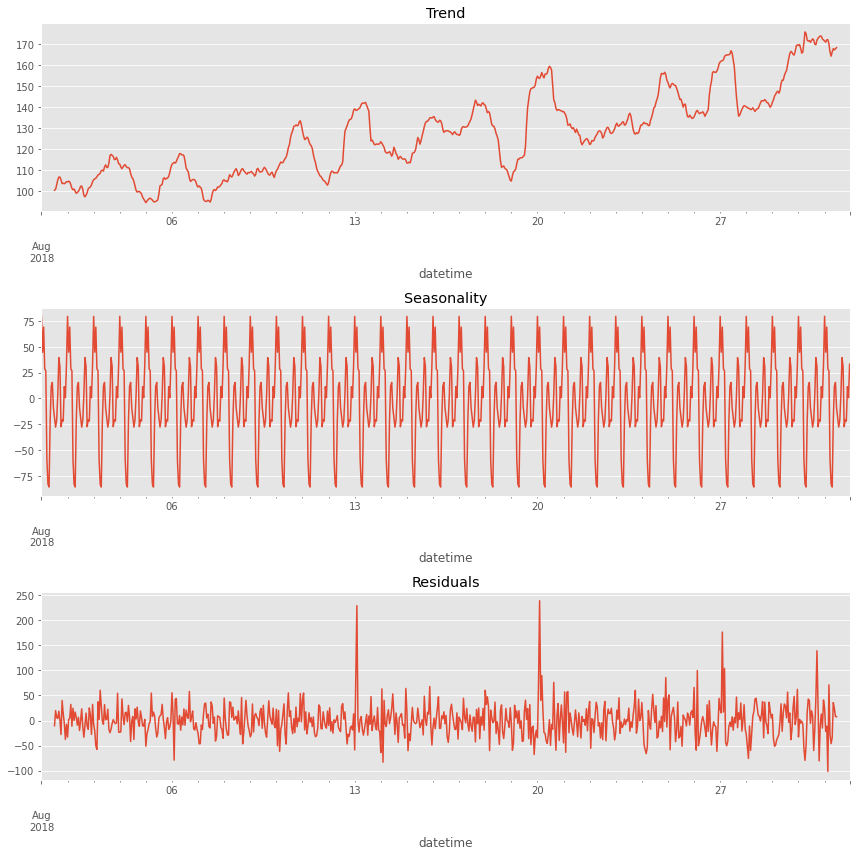

In [7]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(taxi['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

- Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
- Случайная часть также имеет постоянной среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам)
- Трэнд показывает линейный рост количества заказов со временем. 

Построим тренд для всего временного ряда, чтобы увидеть полную картину.

Text(0.5, 1.0, 'Trend')

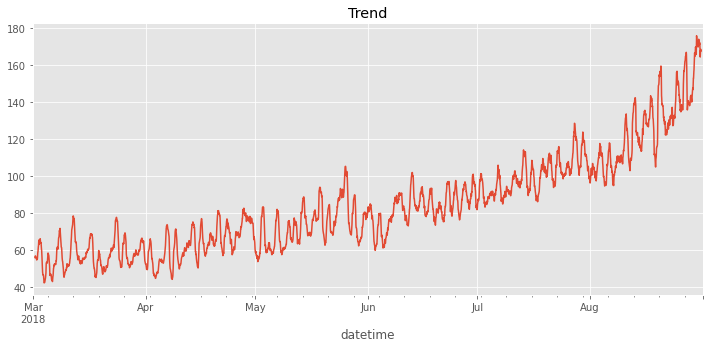

In [8]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(12, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

**Вывод:**
- Трэнд имеет более сложную зависимость от времени (квадраичная или экспоненциальная, сложно оценить по днной выборке). Для нашей задачи будем считать его линейным (предсказания нам нужны всего на час вперёд).
- Также заметим, что линия тренда имеет некоторый шум. Возможно, для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов.

<a id='section3'></a>
## Обучение

В качестве baseline модели будем предсказывать новые значения предыдущими

In [9]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.2)
train = train.dropna()
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE baseline модели:", round(rmse_base, 3))

RMSE baseline модели: 53.368


Проверим предсказания по среднему значению

In [10]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE baseline модели:", mean_squared_error(test['num_orders'], pred_mean) ** 0.5)

RMSE baseline модели: 74.42015786913375


Предсказания по предыдущему значению показывают лучший результат. Возьмём их в качестве baseline.

Напишем функцию для создания обучающих признаков. Создадим признаки day, dayofweek. А также признаки для скользящего среднего rolling_mean (с размером окна rolling_mean_size), и lag_i для признаков отстающего значения.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [12]:
df = make_features(taxi, 30, 50)

Для начала обучим линейную регрессию. Разделим данные в соотношении 9:1 (10% тестовой выборки).

In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [14]:
train.head()

num_orders  dayofweek  lag_1  lag_2  lag_3  lag_4  lag_5  \
datetime                                                                        
2018-03-03 02:00:00          25          5  108.0  163.0   72.0  119.0  101.0   
2018-03-03 03:00:00          64          5   25.0  108.0  163.0   72.0  119.0   
2018-03-03 04:00:00          44          5   64.0   25.0  108.0  163.0   72.0   
2018-03-03 05:00:00          15          5   44.0   64.0   25.0  108.0  163.0   
2018-03-03 06:00:00           9          5   15.0   44.0   64.0   25.0  108.0   

                     lag_6  lag_7  lag_8  ...  lag_22  lag_23  lag_24  lag_25  \
datetime                                  ...                                   
2018-03-03 02:00:00   93.0   49.0   89.0  ...    20.0    64.0    75.0   120.0   
2018-03-03 03:00:00  101.0   93.0   49.0  ...    11.0    20.0    64.0    75.0   
2018-03-03 04:00:00  119.0  101.0   93.0  ...    11.0    11.0    20.0    64.0   
2018-03-03 05:00:00   72.0  119.0  101.0  ...     7.0    11.0    11.0    20.0   
2018-03-03 06:00:00  163.0   72.0  119.0  ...    46.0     7.0    11.0    11.0   

                     lag_26  lag_27  lag_28  lag_29  lag_30  rolling_mean  
datetime                                                                   
2018-03-03 02:00:00    90.0    58.0   113.0    66.0    61.0         62.82  
2018-03-03 03:00:00   120.0    90.0    58.0   113.0    66.0         60.84  
2018-03-03 04:00:00    75.0   120.0    90.0    58.0   113.0         60.42  
2018-03-03 05:00:00    64.0    75.0   120.0    90.0    58.0         59.88  
2018-03-03 06:00:00    20.0    64.0    75.0   120.0    90.0         58.86  

[5 rows x 33 columns]

Выделим признаки, целевой признак для обучающей и тестовой выборок

In [15]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

Подберём параметры для линейной регрессии

In [16]:
%%time
best_lag_lm = 0
best_roll_size_lm = 0
best_rmse_lm = 48
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):

        df = make_features(taxi, lag, roll_size)
        train, valid = train_test_split(df, shuffle=False, test_size=0.2)
        train = train.dropna()
        X_train = train.drop('num_orders', axis = 1)
        y_train = train['num_orders']
        X_valid = valid.drop('num_orders', axis = 1)
        y_valid = valid['num_orders']

        LR_lm = LinearRegression()
        LR_lm.fit(X_train, y_train)

        preds_valid = LR_lm.predict(X_valid)
        rmse = mean_squared_error(y_valid, preds_valid) ** 0.5
        if rmse < best_rmse_lm :
            best_rmse_lm = rmse
            best_lag_lm = lag
            best_roll_size_lm = roll_size
            
print(f"RMSE на валидационной выборке: {best_rmse_lm}, максимальное смещение {best_lag_lm}, размер скользящего окна {best_roll_size_lm}")

RMSE на валидационной выборке: 35.69364913834159, максимальное смещение 96, размер скользящего окна 16
CPU times: user 43.1 s, sys: 1min 5s, total: 1min 48s
Wall time: 1min 48s


Попробуем обучить модель с регуляризацией. Например, Lasso с L1 регуляризацией.

In [17]:
def model_build(model):
    best_lag = 0
    best_roll_size = 0
    best_alpha = 0
    best_rmse = 48
    for lag in range(1, 101, 5):
        for roll_size in range(1, 101, 5):
            for alpha in np.arange(0.1, 1, 0.2):

                df = make_features(taxi, lag, roll_size)
                train, valid = train_test_split(df, shuffle=False, test_size=0.2)
                train = train.dropna()
                X_train = train.drop('num_orders', axis = 1)
                y_train = train['num_orders']
                X_valid = valid.drop('num_orders', axis = 1)
                y_valid = valid['num_orders']
                
                if model == 'Lasso' :
                    lm = Lasso(alpha=alpha)
                elif model == 'Ridge' :
                    lm = Ridge(alpha=alpha)
                lm.fit(X_train, y_train)

                preds_valid = lm.predict(X_valid)
                rmse = mean_squared_error(y_valid, preds_valid) ** 0.5
                if rmse < best_rmse :
                    best_rmse = rmse
                    best_lag = lag
                    best_roll_size = roll_size
                    best_alpha = alpha
    return best_rmse, best_lag, best_roll_size, best_alpha

In [18]:
%%time
best_rmse_ls, best_lag_ls, best_roll_size_ls, best_alpha_ls = model_build("Lasso")
print(f" Модель Lasso ")
print(f"RMSE на валидационной выборке: {best_rmse_ls}, максимальное смещение {best_lag_ls}, размер скользящего окна {best_roll_size_ls}")
print(f"Коэффициент регуляризации: {best_alpha_ls}")

 Модель Lasso 
RMSE на валидационной выборке: 35.67281060216996, максимальное смещение 96, размер скользящего окна 41
Коэффициент регуляризации: 0.9000000000000001
CPU times: user 5min 25s, sys: 7min 37s, total: 13min 2s
Wall time: 13min 3s


In [19]:
%%time
best_rmse_rg, best_lag_rg, best_roll_size_rg, best_alpha_rg = model_build("Ridge")
print(f" Модель Ridge ")
print(f"RMSE на валидационной выборке: {best_rmse_rg}, максимальное смещение {best_lag_rg}, размер скользящего окна {best_roll_size_rg}")
print(f"Коэффициент регуляризации: {best_alpha_rg}")

 Модель Ridge 
RMSE на валидационной выборке: 35.694169666362185, максимальное смещение 96, размер скользящего окна 1
Коэффициент регуляризации: 0.1
CPU times: user 2min 50s, sys: 3min 55s, total: 6min 45s
Wall time: 6min 45s


**Вывод:**

- Обучены модели LinearRegression, Lasso, Ridge с различными гиперпараметрами.
- Проведена проверка моделей на валидационной выборке размером 20% от исходных данных.
- Все модели показали похожий результат по RMSE который удовлетворяет условию задачи.


<a id='section4'></a>
## Тестирование и итоговый анализ

Проведем тестирование моделей на тестовой выборке

In [20]:
%%time
LR_lm.fit(X_test, y_test)
preds_test = LR_lm.predict(X_test)
rmse_test_lr = mean_squared_error(y_test, preds_test) ** 0.5
print(f" Модель LinearRegression ")
print(f"RMSE на тестовой: {rmse_test_lr}")

 Модель LinearRegression 
RMSE на тестовой: 41.406604223029085
CPU times: user 21.3 ms, sys: 50 ms, total: 71.3 ms
Wall time: 98.5 ms


In [21]:
%%time
lasso = Lasso(alpha=0.9)
lasso.fit(X_test, y_test)
preds_test = lasso.predict(X_test)
rmse_test_lasso = mean_squared_error(y_test, preds_test) ** 0.5
print(f" Модель Lasso ")
print(f"RMSE на валидационной выборке: {rmse_test_lasso}")

 Модель Lasso 
RMSE на валидационной выборке: 41.41021836394594
CPU times: user 12.1 ms, sys: 32.4 ms, total: 44.4 ms
Wall time: 8.04 ms


In [22]:
%%time
ridge = Ridge(alpha=0.1)
ridge.fit(X_test, y_test)
preds_test = ridge.predict(X_test)
rmse_test_ridge = mean_squared_error(y_test, preds_test) ** 0.5
print(f" Модель Ridge ")
print(f"RMSE на валидационной выборке: {rmse_test_ridge}")

 Модель Ridge 
RMSE на валидационной выборке: 41.40660422337304
CPU times: user 25.8 ms, sys: 82.7 ms, total: 109 ms
Wall time: 91.9 ms


Соберём данные в таблицу и проанализируем результат.

In [23]:
stats = pd.DataFrame([['Baseline', round(rmse_base, 3)],
                      ['Linear Regression', round(rmse_test_lr, 3)],
                      ['Lasso', round(rmse_test_lasso, 3)],
                      ['Ridge', round(rmse_test_ridge, 3)]],
                    columns = ['model', 'rmse'])

In [24]:
stats

model    rmse
0           Baseline  53.368
1  Linear Regression  41.407
2              Lasso  41.410
3              Ridge  41.407

Для предсказаний модели Lasso с параметром регуляризации alpha=0.9 построим графики зависимостей целевого признака и предсказаний от времени. Проверим, в какие моменты модель была более точной и менее точной. Для наглядности графика построим последние 3 дня

In [25]:
df = make_features(taxi, 96, 41)
train, valid = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_valid = valid.drop('num_orders', axis = 1)
y_valid = valid['num_orders']

lasso = Lasso(alpha=0.9)
lasso.fit(X_train, y_train)
preds_valid = pd.Series(lasso.predict(X_valid), index = y_valid.index, name='preds')

In [26]:
df_preds = pd.concat([y_valid, preds_valid], axis=1)
df_preds.head(10)

num_orders       preds
datetime                                   
2018-08-13 14:00:00         102  125.239199
2018-08-13 15:00:00         175  135.659638
2018-08-13 16:00:00         144  163.643824
2018-08-13 17:00:00         152  131.371846
2018-08-13 18:00:00         104  106.758117
2018-08-13 19:00:00          91  101.907253
2018-08-13 20:00:00          82   85.535038
2018-08-13 21:00:00         160  129.903128
2018-08-13 22:00:00         104  133.062276
2018-08-13 23:00:00         134  151.117429

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

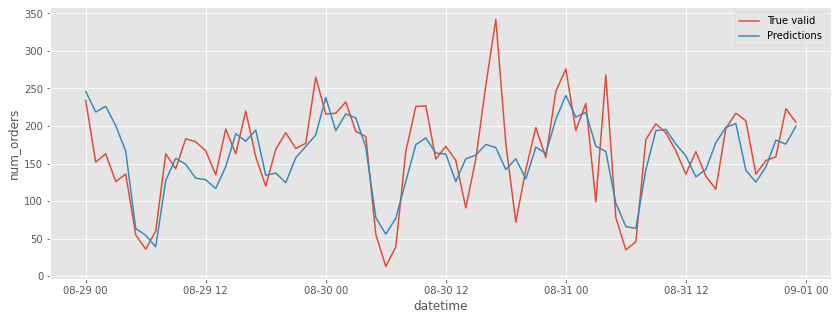

In [27]:
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
data = df_preds['2018-08-29':]
sns.lineplot(x=data.index, y=data['num_orders'], label='True valid')
sns.lineplot(x=data.index, y=data['preds'], label='Predictions')

По графику видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Однако редки пики в данных (возможно, рост спроса на такси по выходным) предсказать не может. Возможно, для этого необходимо ввести признак 'выходной день'.

**Общий вывод:**

- Все линейные модели показали похожий результат по RMSE.
- Максимальное смещение ограничено значением 100 ввиду сложности модели. Дальше показатель RMSE не сильно растёт.
- Как и предполагалось, наилучшие результат даёт скользящее окно размером ~40-50 часов (около двух дней, это значение хорошо сглаживает кривую тренда, судя по графику.)
- Каждая из моделей показала результат RMSE на 25% меньше относительно baseline.
- По графику видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Однако редкие пики в данных предсказать не может.